## Vector Search - Azure Database for PostgreSQL

### Prerequisites
  
- Generate embeddings - [generate_embeddings.ipynb](../common/generate_embeddings.ipynb)
- Create table and ingest embeddings - [postgresql_data_pipeline.ipynb](.../postgresql_data_pipeline.ipynb)

#### Set environment variables

In [2]:
import os
from dotenv import load_dotenv
import openai

load_dotenv()

pg_host  = os.getenv("POSTGRESQL_HOST")
if pg_host is None or pg_host == "":
    print("POSTGRESQL_HOST environment variable not set.")
    exit()

pg_user  = os.getenv("POSTGRESQL_USERNAME")
if pg_user is None or pg_user == "":
    print("POSTGRESQL_USERNAME environment variable not set.")
    exit()

pg_password  = os.getenv("POSTGRESQL_PASSWORD")
if pg_password is None or pg_password == "":
    print("POSTGRESQL_PASSWORD environment variable not set.")
    exit()

db_name  = os.getenv("POSTGRESQL_DATABASE")
if db_name is None or db_name == "":
    print("POSTGRESQL_DATABASE environment variable not set.")
    exit()

aoai_endpoint  = os.getenv("AOAI_ENDPOINT")
if aoai_endpoint is None or aoai_endpoint == "":
    print("AOAI_ENDPOINT environment variable not set.")
    exit()

aoai_api_version  = os.getenv("AOAI_API_VERSION")
if aoai_api_version is None or aoai_api_version == "":
    print("AOAI_API_VERSION environment variable not set.")
    exit()

aoai_embedding_deployed_model  = os.getenv("AOAI_EMBEDDING_DEPLOYED_MODEL")
if aoai_embedding_deployed_model is None or aoai_embedding_deployed_model == "":
    print("AOAI_EMBEDDING_DEPLOYED_MODEL environment variable not set.")
    exit()

azure_openai_key  = os.getenv("AZURE_OPENAI_KEY")
if azure_openai_key is None or azure_openai_key == "":
    print("AZURE_OPENAI_KEY environment variable not set.")
    exit()

com_vision_endpoint  = os.getenv("COM_VISION_ENDPOINT")
if com_vision_endpoint is None or com_vision_endpoint == "":
    print("COM_VISION_ENDPOINT environment variable not set.")
    exit()

com_vision_api_version  = os.getenv("COM_VISION_API_VERSION")
if com_vision_api_version is None or com_vision_api_version == "":
    print("COM_VISION_API_VERSION environment variable not set.")
    exit()

com_vision_key  = os.getenv("COM_VISION_KEY")
if com_vision_key is None or com_vision_key == "":
    print("COM_VISION_KEY environment variable not set.")
    exit()

text_table_name = 'text_sample'
doc_table_name = 'doc_sample'
image_table_name = 'image_sample'

openai.api_type = "azure"
openai.api_key = azure_openai_key
openai.api_base = aoai_endpoint
openai.api_version = aoai_api_version

postgresql_params = {
    "host": pg_host,
    "port": "5432", 
    "dbname": db_name,
    "user": pg_user,
    "password": pg_password,
    "sslmode": "require"
}

#### Helper method

In [4]:
import requests

def vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query):
    vectorize_text_url = f"{com_vision_endpoint}/computervision/retrieval:vectorizeText"  
    params = {  
        "api-version": "2023-02-01-preview"  
    } 
    headers = {  
        "Content-Type": "application/json",  
        "Ocp-Apim-Subscription-Key": com_vision_key  
    }  
    data = {
        'text':query
    }

    response = requests.post(vectorize_text_url, params=params, headers=headers, json=data)
    query_vector = response.json()["vector"]

    return query_vector

def show_image(image_folder, image):
    image_path = os.path.join(image_folder, image)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()

#### Simple vector search

This demo shows how to apply vector search on single field.

In [9]:
from psycopg2 import connect
from openai import AzureOpenAI

azure_oai_client = AzureOpenAI(
  api_key = azure_openai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'web hosting services'
query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

with connect(**postgresql_params) as connection:
    with connection.cursor() as cursor:
        # Postgres supports L2 distance (<->), inner product (<#>) and cosine distance (<=>)
        query_sql = f"""
          SET hnsw.ef_search = 500;
          SELECT title, category FROM {text_table_name} ORDER BY ((content_vector <=> '{query_vector}')) LIMIT 5;
        """
        cursor.execute(query_sql)
        records = cursor.fetchall()

        for row in records:
                print(row[0], row[1])

Azure App Service Web
Azure Static Web Apps Web
Azure Virtual Machines Compute
Azure CDN Networking
Azure Media Services Media


#### Metadata filtering with vector search

This demo shows how to apply metadata filtering (SQL - where, order by etc.) on top of vector search.

In [10]:
from psycopg2 import connect
from openai import AzureOpenAI

azure_oai_client = AzureOpenAI(
  api_key = azure_openai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'web hosting services'
query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

with connect(**postgresql_params) as connection:
    with connection.cursor() as cursor:
        # Postgres supports L2 distance (<->), inner product (<#>) and cosine distance (<=>)
        query_sql = f"""
          SET hnsw.ef_search = 500;
          SELECT title, category FROM {text_table_name} WHERE category = 'Web' ORDER BY ((content_vector <=> '{query_vector}')) LIMIT 5;
        """
        cursor.execute(query_sql)
        records = cursor.fetchall()

        for row in records:
                print(row[0], row[1])

Azure App Service Web
Azure Static Web Apps Web
Azure SignalR Service Web
Azure Web PubSub Web


#### Cross column vector search

This demo shows how to apply vector search on multiple columns.

In [20]:
from psycopg2 import connect
from openai import AzureOpenAI

azure_oai_client = AzureOpenAI(
  api_key = azure_openai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'tools for software development'
query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

with connect(**postgresql_params) as connection:
    with connection.cursor() as cursor:
        query_sql = f'''
            SET hnsw.ef_search = 500;
            (
                SELECT title, ((title_vector <-> '{query_vector}')) AS content_similarity FROM text_sample
                union
                SELECT title, ((content_vector <-> '{query_vector}')) AS content_similarity FROM text_sample
            ) ORDER BY content_similarity LIMIT 5;
        '''
        cursor.execute(query_sql)
        records = cursor.fetchall()

        for row in records:
                print(row[0])

Azure DevOps
Azure DevTest Labs
Azure DevOps
Azure Static Web Apps
Azure DevTest Labs


#### Hybrid search

- This demo shows how to apply vector search in in conjunction with additional search methods, such as lexical search. 

- Implement a hybrid search that combines semantic keyword search by reranking. Details - https://github.com/pgvector/pgvector-python/blob/master/examples/hybrid_search.py

In [21]:
import itertools
from sentence_transformers import CrossEncoder, SentenceTransformer
from openai import AzureOpenAI
from psycopg2 import connect

azure_oai_client = AzureOpenAI(
  api_key = azure_openai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'database'

def semantic_search(query):
    query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

    with connect(**postgresql_params) as connection:
        with connection.cursor() as cursor:
            # Postgres supports L2 distance (<->), inner product (<#>) and cosine distance (<=>)
            query_sql = f"""
                SET hnsw.ef_search = 500;
                SELECT title FROM text_sample ORDER BY ((content_vector <=> '{query_vector}')) LIMIT 5;
            """
            cursor.execute(query_sql)
            return cursor.fetchall()

def keyword_search(query):
    with connect(**postgresql_params) as connection:
        with connection.cursor() as cursor:
            cursor.execute("""
                SET hnsw.ef_search = 500;
                SELECT title FROM text_sample, plainto_tsquery('english', %s) query WHERE to_tsvector('english', content) @@ query ORDER BY ts_rank_cd(to_tsvector('english', content), query) DESC LIMIT 5
            """, (query,))
            return cursor.fetchall()

def rerank(query, records):
    # deduplicate
    results = set(itertools.chain(*records))

    # re-rank
    encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    scores = encoder.predict([(query, item[1]) for item in results])
    return [v for _, v in sorted(zip(scores, results), reverse=True)]

keyword_search_records = keyword_search(query)
semantic_search_records = semantic_search(query)

records = list(semantic_search_records) + (list(keyword_search_records))
results = rerank(query, records)

print(results)

ModuleNotFoundError: No module named 'sentence_transformers'

#### Document search example

This demo shows how to apply vector search for srarching within documents.

In [7]:
from psycopg2 import connect
from openai import AzureOpenAI

azure_oai_client = AzureOpenAI(
  api_key = azure_openai_key,  
  api_version = aoai_api_version,
  azure_endpoint = aoai_endpoint
)

query = 'web hosting services'
query_vector = azure_oai_client.embeddings.create(input = [query], model=aoai_embedding_deployed_model).data[0].embedding

with connect(**postgresql_params) as connection:
    with connection.cursor() as cursor:

        # Postgres supports L2 distance (<->), inner product (<#>) and cosine distance (<=>)
        query_sql = f"""
          SET hnsw.ef_search = 500;
          SELECT chunk_content FROM doc_sample ORDER BY ((chunk_content_vector <=> '{query_vector}')) LIMIT 5;
        """
        cursor.execute(query_sql)
        records = cursor.fetchall()

        for row in records:
                print(row[0], )

from unauthorized access, alteration, or disclosure.  
 
We use secure servers and encryption technology to protect data transmitted over the 
Internet.  
 
Access to Personal Information  
 
You have the right to access, review, and request a copy of your personal information that 
we have collected and stored. You may al so request that we delete or correct any inaccurate 
information.  
 
To access or make changes to your personal information, please contact the Privacy Officer 
at privacy@contoso.com.  
 
Changes to This Policy  
 
We may update this policy from time to time to ref lect changes in our practices or 
applicable laws. We will notify you of any changes by posting a revised policy on our  website.  
 
Questions or Concerns  
 
If you have any questions or concerns about our privacy policies or practices, please contact 
the Privac y Officer at privacy@contoso.com.  
Whistleblower Policy  
 
Contoso Electronics Whistleblower Policy
have a comprehensive data security pro 

#### Image search example

This demo shows how to apply vector search for searching images.

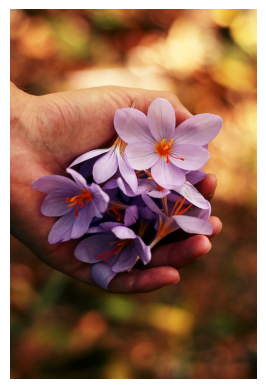

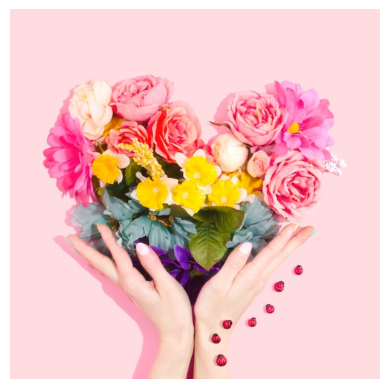

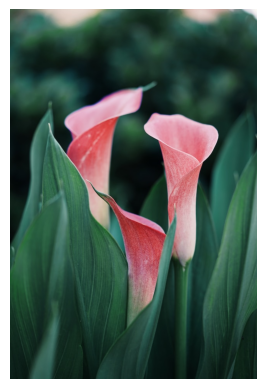

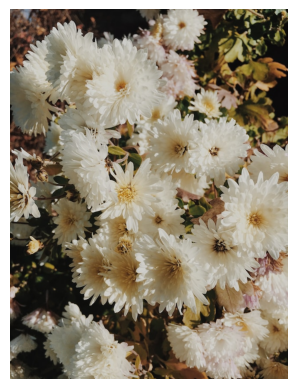

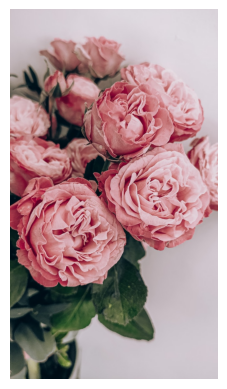

In [8]:
from psycopg2 import connect
import matplotlib.pyplot as plt
from PIL import Image

query = 'flower with hand'
image_folder = "../data/images"
query_vector = vectorize_text_com_vision(com_vision_endpoint,com_vision_key,query)

with connect(**postgresql_params) as connection:
    with connection.cursor() as cursor:
        # Postgres supports L2 distance (<->), inner product (<#>) and cosine distance (<=>)
        query_sql = f"""
            SET hnsw.ef_search = 500;
            SELECT image FROM image_sample ORDER BY ((image_vector <=> '{query_vector}')) LIMIT 5;
        """
        cursor.execute(query_sql)
        records = cursor.fetchall()

        for result in records:
            show_image(image_folder, result[0])
            print("\n")